Words in index: 22101

 Evaluation of model with ALL layers fine-tuned:

 Evaluation of model with LAST layer fine-tuned:

 Evaluation of model trained from scratch:


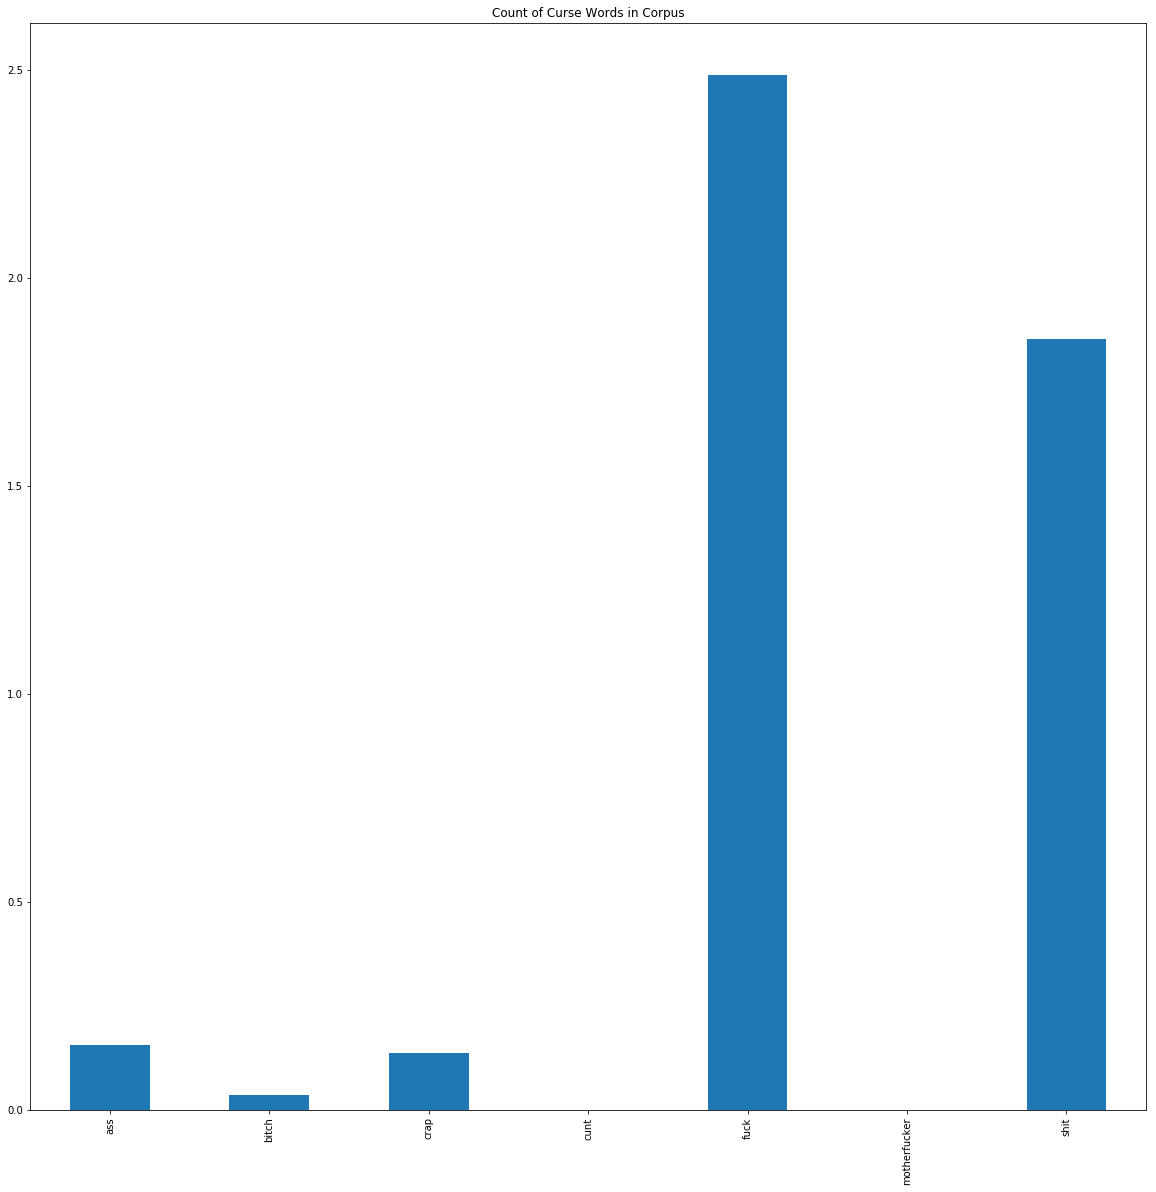

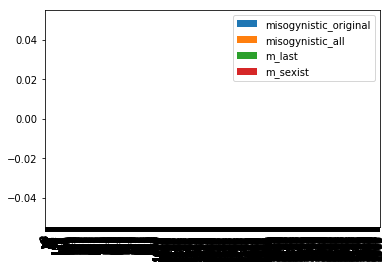

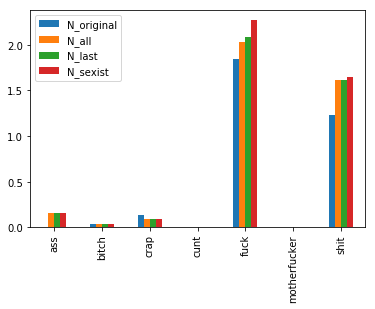

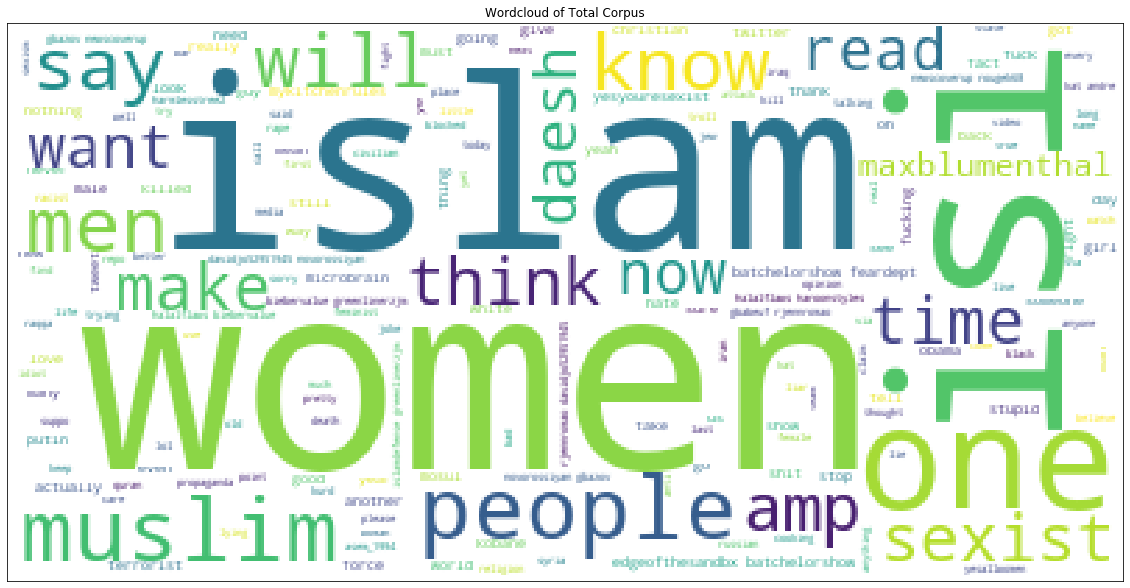

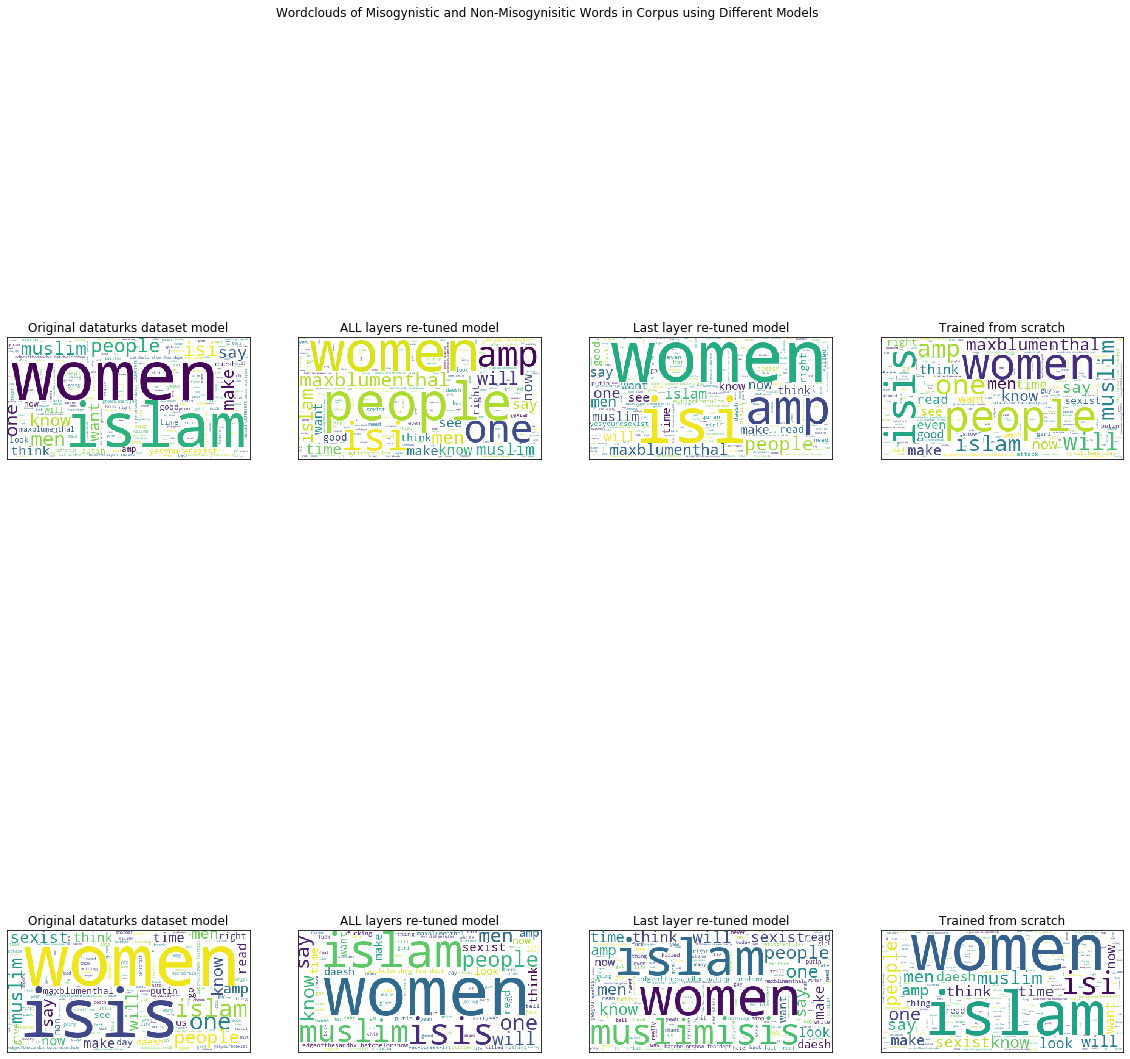

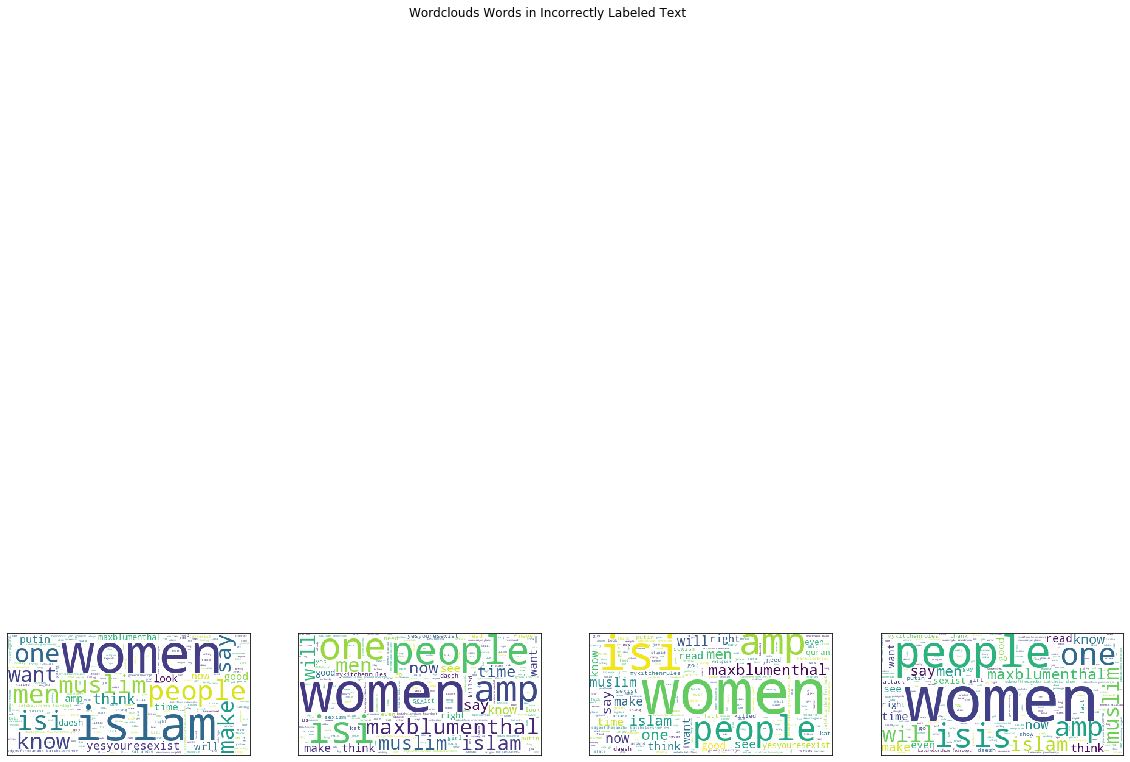

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from src.data.preprocess.dataturks.preprocess_translearn_hatespeech import create_NN_sets
from src.evaluation.hatespeech.evaluation_translearn_hatespeech import evaluate_best_model, get_predictions, \
    draw_wordcloud, density_of_curse_words
from src.models.hatespeech.model_translearn_hatespeech import fine_tune_model, create_model

np.random.seed(42)
vocab_size = 10000
path_to_target_data = "../../data/external/hatespeech/clean_sexism_dataset.csv"
path_to_original_model = "../../models/example_dataturks.h5"
path_to_fine_tuned_model = "../../models/fine_tuned.h5"
path_to_fine_tuned_model_last = "../../models/fine_tuned_last_layer.h5"
path_to_sexist_model = "../../models/zeerak_model.h5"

datasets = create_NN_sets(path_to_target_data, vocab_size)
#fine_tune_model(path_to_original_model, path_to_fine_tuned_model, datasets)
print("\n Evaluation of model with ALL layers fine-tuned:")
#evaluate_best_model(path_to_fine_tuned_model, datasets[4], datasets[5], datasets[6], 10000)

# fine_tune_model(path_to_original_model, path_to_fine_tuned_model2, datasets)
print("\n Evaluation of model with LAST layer fine-tuned:")
#evaluate_best_model(path_to_fine_tuned_model_last, datasets[4], datasets[5], datasets[6], 10000)

# train_model(path_to_sexist_model, datasets, vocab_size)
print("\n Evaluation of model trained from scratch:")
#evaluate_best_model(path_to_sexist_model, datasets[4], datasets[5], datasets[6], 10000)


def returns_predictions(path_to_model, differences = False):
    """ Returns the dataframe with only the rows where the labeling is different
    Args:
        path_to_model (str) : the path the to model to be studied.
        
    Returns:
        df (pandas df) : the dataframe containing rows where the labeling was different.
    """
    data = pd.read_csv(path_to_target_data)
    best_model = create_model(datasets[6], vocab_size)
    best_model.load_weights(path_to_model)
    
    predictions = get_predictions(best_model, datasets[4])
    df_pred = pd.DataFrame({"prediction":predictions})
    df_test = data.loc[datasets[5].index, :].reset_index()
    df = pd.concat([df_test, df_pred], axis = 1)
    if differences == False:
        return df
    else:
        return df.loc[df.loc[:, "label"] != df.loc[:, "prediction"]]

def return_misogynistic_or_not(df, misogynstic = True):
    """Returns the predicted or not predicted misogynistic data."""
    if misogynstic == True:
        return df.loc[df.loc[:, "prediction"] == 1]
    else:
        return df.loc[df.loc[:, "prediction"] == 0]

### Exploratory Data Analysis of Predictions

df_original = returns_predictions(path_to_original_model)
df_all = returns_predictions(path_to_fine_tuned_model)
df_last = returns_predictions(path_to_fine_tuned_model_last)
df_sexist = returns_predictions(path_to_sexist_model) 

## DENSITY OF CURSEWORDS
df_original['curse_words'] = df_original['text'].apply(lambda tweet: density_of_curse_words(tweet))
df_all['curse_words'] = df_all['text'].apply(lambda tweet: density_of_curse_words(tweet))
df_last['curse_words'] = df_all['text'].apply(lambda tweet: density_of_curse_words(tweet))
df_sexist['curse_words'] = df_sexist['text'].apply(lambda tweet: density_of_curse_words(tweet)) 

fig, ax = plt.subplots(figsize=(20,20))
ax = pd.DataFrame(list(df_original['curse_words'])).T.sum(axis=1).plot.bar()
ax.set_title('Count of Curse Words in Corpus', fontsize=12)
plt.savefig("curse_words_total_corpus.png")    
plt.show()

def count_number_of_cursewords(df, dataset_title, misogynistic = True):
    if misogynistic == True:
        count = pd.DataFrame(list(return_misogynistic_or_not(df)['curse_words'])).T.sum(axis=1)
    else:
        count = pd.DataFrame(list(return_misogynistic_or_not(df, misogynstic=False)['curse_words'])).T.sum(axis=1)
    return pd.DataFrame({dataset_title: count}, index = count.index)

misogynistic_original = count_number_of_cursewords(df_original, "misogynistic_original")
misogynistic_all = count_number_of_cursewords(df_all, "misogynistic_all")
misogynistic_last = count_number_of_cursewords(df_last, "misogynistic_last")
misogynistic_sexist = count_number_of_cursewords(df_sexist, "misogynistic_sexist")

not_misogynistic_original = count_number_of_cursewords(df_original, "not_misogynistic", misogynistic=False) 
not_misogynistic_all = count_number_of_cursewords(df_all, "not_misogynistic_all", misogynistic=False)
not_misogynistic_last = count_number_of_cursewords(df_last, "not_misogynistic_last", misogynistic=False)
not_misogynistic_sexist = count_number_of_cursewords(df_sexist, "not_misogynistic_sexist", misogynistic=False)

pd.concat([misogynistic_original, misogynistic_all, misogynistic_last, misogynistic_sexist], axis =1).plot.bar()
plt.savefig("misogynistic_cursewords_models_corpus.png")
plt.show()

pd.concat([not_misogynistic_original, not_misogynistic_all, not_misogynistic_last, not_misogynistic_sexist], axis =1).plot.bar()
plt.savefig("not_misogynistic_cursewords_models_corpus.png")
plt.show()

## WORDCLOUDS

# All text
fig, ax = plt.subplots(figsize=(20,20))
ax.imshow(draw_wordcloud(df_original['text']))
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_title('Wordcloud of Total Corpus', fontsize=12)
plt.savefig("total_corpus.png")

# Misogynistic and not
fig, ax = plt.subplots(2, 4, sharey=True, figsize=(20,20))
for i in range(0,2):
    for j in range(0, 4):   
        ax[i, j].xaxis.set_visible(False)
        ax[i, j].yaxis.set_visible(False)

fig.suptitle("Wordclouds of Misogynistic and Non-Misogynisitic Words in Corpus using Different Models")
ax[0, 0].imshow(draw_wordcloud(return_misogynistic_or_not(df_original)['text']))
ax[0, 0].set_title("Original dataturks dataset model")
ax[0, 1].imshow(draw_wordcloud(return_misogynistic_or_not(df_all)['text']))
ax[0, 1].set_title("ALL layers re-tuned model")
ax[0, 2].imshow(draw_wordcloud(return_misogynistic_or_not(df_last)['text']))
ax[0, 2].set_title("Last layer re-tuned model")
ax[0, 3].imshow(draw_wordcloud(return_misogynistic_or_not(df_sexist)['text']))
ax[0, 3].set_title("Trained from scratch")

ax[1, 0].imshow(draw_wordcloud(return_misogynistic_or_not(df_original, misogynstic=False)['text']))
ax[1, 0].set_title("Original dataturks dataset model")
ax[1, 1].imshow(draw_wordcloud(return_misogynistic_or_not(df_all, misogynstic=False)['text']))
ax[1, 1].set_title("ALL layers re-tuned model")
ax[1, 2].imshow(draw_wordcloud(return_misogynistic_or_not(df_last, misogynstic=False)['text']))
ax[1, 2].set_title("Last layer re-tuned model")
ax[1, 3].imshow(draw_wordcloud(return_misogynistic_or_not(df_sexist, misogynstic=False)['text']))
ax[1, 3].set_title("Trained from scratch")

plt.savefig("labelled_text.png")

# Error Analysis
incorrect_df_original = returns_predictions(path_to_original_model, differences=True)
incorrect_df_all = returns_predictions(path_to_fine_tuned_model, differences=True)
incorrect_df_last = returns_predictions(path_to_fine_tuned_model_last, differences=True)
incorrect_df_sexist = returns_predictions(path_to_sexist_model, differences=True)

fig, ax = plt.subplots(1, 4, sharey=True, figsize=(20,20))
fig.suptitle("Wordclouds Words in Incorrectly Labeled Text")
for i in range(0,4):
    ax[i].xaxis.set_visible(False)
    ax[i].yaxis.set_visible(False)
ax[0].imshow(draw_wordcloud(incorrect_df_original['text']))
ax[1].imshow(draw_wordcloud(incorrect_df_all['text']))
ax[2].imshow(draw_wordcloud(incorrect_df_last['text']))
ax[3].imshow(draw_wordcloud(incorrect_df_sexist['text']))
plt.plot()
plt.savefig("words_in_incorretly_labelled_text.png")
plt.show()